In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

## Import Data

In [2]:
# Import descriptions of each column of the dataset from the first sheet

column_names_df = pd.read_excel('./data/Songs_2025.xlsx')

column_names_df

,year,year.1
0,track_name,track name
1,track_popularity,track popularity from 0 to 100
2,album,album the track appears on
3,artist_name,artist name
4,artist_genres,list of the Genres the artist is associated with
5,artist_popularity,"artist popularity from 0 to 100, being the max..."
6,danceability,a value of 0.0 is least danceable and 1.0 is m...
7,energy,a measure from 0.0 to 1.0 and represents a per...
8,key,The key the track is in. Integers map to pitch...
9,loudness,The overall loudness of a track in decibels (dB)


In [3]:
# Import numeric data

df = pd.read_excel('./data/Songs_2025.xlsx',sheet_name='spotify songs')
df['artist_genres'] = df['artist_genres'].str.lstrip('"[').str.rstrip(']"').str.replace("'","").str.strip(' ').str.split('; ')
df['track_id'] = pd.Series(range(len(df)))

df

,year,track_name,track_popularity,album,artist_name,artist_genres,artist_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,track_id
0,2000,7 Days,73,Born to Do It,Craig David,[british soul],62,0.659,0.812,4.0,87.0,0.0,0.0487,0.230000,0.000000,0.0951,0.888,83.014,235133.0,0
1,2000,Absolutely (Story of a Girl) - Radio Mix,69,The Madding Crowd,Nine Days,[pop rock],49,0.481,0.940,7.0,71.0,1.0,0.0660,0.000891,0.000000,0.0939,0.660,96.493,189333.0,1
2,2000,Against All Odds (Take A Look at Me Now) - Mar...,61,Against All Odds (Take A Look at Me Now) EP,Mariah Carey,"[dance pop, pop, urban contemporary]",76,0.542,0.498,1.0,80.0,1.0,0.0299,0.490000,0.000000,0.1010,0.218,117.763,201933.0,2
3,2000,All The Small Things,84,Enema Of The State,blink-182,"[alternative metal, modern rock, pop punk, pun...",75,0.434,0.897,0.0,69.0,1.0,0.0488,0.010300,0.000000,0.6120,0.684,148.726,167067.0,3
4,2000,Amazed,72,Lonely Grill,Lonestar,"[contemporary country, country, country road]",57,0.561,0.543,1.0,92.0,1.0,0.0324,0.260000,0.000000,0.1240,0.243,139.803,240867.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2295,2022,We Don't Talk About Bruno,77,Encanto (Original Motion Picture Soundtrack),Carolina GaitÃ¡n - La Gaita,[movie tunes],56,0.577,0.450,0.0,93.0,0.0,0.0834,0.357000,0.000000,0.1110,0.830,205.863,216120.0,2295
2296,2022,When You're Gone,78,When You're Gone,Shawn Mendes,"[canadian pop, pop, viral pop]",81,0.603,0.691,5.0,76.0,1.0,0.0372,0.024800,0.000000,0.5830,0.577,147.148,172267.0,2296
2297,2022,Where Are You Now,87,Where Are You Now,Lost Frequencies,"[belgian edm, edm, pop dance, tropical house]",76,0.671,0.636,6.0,90.0,0.0,0.1030,0.515000,0.000411,0.1720,0.262,120.966,148197.0,2297
2298,2022,Woman,87,Planet Her,Doja Cat,"[dance pop, pop]",86,0.824,0.764,5.0,62.0,0.0,0.0854,0.088800,0.002940,0.1170,0.881,107.998,172627.0,2298


In [4]:
# Get count of unique songs per genre and save as csv

unique_genre_counts = pd.DataFrame(df['artist_genres']
                        .explode()
                        .value_counts()
                        .sort_values(ascending=False)).reset_index()

unique_genre_counts.to_csv('./data/data.csv')

In [5]:
# Read in the pre-segmented genres and group them by ID in a dataframe

segmented_genres = pd.read_csv('./data/segmented_genres.csv')

genre_groups = segmented_genres[['ID','artist_genres']].groupby('ID')['artist_genres'].apply(list).reset_index()

genre_groups

,ID,artist_genres
0,Country/Folk,"[country, contemporary country, country road, ..."
1,Electronic,"[edm, electro house, house, progressive house,..."
2,Hip-Hop/Rap,"[rap, hip hop, trap, southern hip hop, atl hip..."
3,Jazz/Blues,"[new jack swing, punk blues, contemporary voca..."
4,Latin,"[urbano latino, reggaeton, reggaeton colombian..."
5,Metal,"[alternative metal, nu metal, industrial metal..."
6,Other,"[urban contemporary, neo mellow, post-grunge, ..."
7,Pop,"[pop, dance pop, pop rap, canadian pop, hip po..."
8,R&B/Soul,"[r&b, contemporary r&b, neo soul, british soul..."
9,Rock,"[modern rock, rock, alternative rock, piano ro..."


In [6]:
# Function to assign broader genres to a song based on its subgenres
def assign_broader_genres(song_genres):
    matched_categories = set()
    
    for _, row in genre_groups.iterrows():
        broader_category = row["ID"]
        subgenres = row["artist_genres"]
        
        # If any subgenre in the song matches this broader category, add it
        if any(sub in subgenres for sub in song_genres):
            matched_categories.add(broader_category)

    return ", ".join(matched_categories) if matched_categories else "Other"

# Apply the function to assign broader genres
df["Broader_Genres"] = df["artist_genres"].apply(assign_broader_genres).str.split(', ')

# Display the modified dataframe
df[['artist_genres','Broader_Genres']]

,artist_genres,Broader_Genres
0,[british soul],[R&B/Soul]
1,[pop rock],[Pop]
2,"[dance pop, pop, urban contemporary]","[Other, Pop]"
3,"[alternative metal, modern rock, pop punk, pun...","[Metal, Other, Rock, Pop]"
4,"[contemporary country, country, country road]",[Country/Folk]
...,...,...
2295,[movie tunes],[Other]
2296,"[canadian pop, pop, viral pop]",[Pop]
2297,"[belgian edm, edm, pop dance, tropical house]","[Electronic, Pop]"
2298,"[dance pop, pop]",[Pop]


In [7]:
genre_dummies = df.explode("Broader_Genres")  # Expands lists into multiple rows
genre_dummies = pd.get_dummies(genre_dummies["Broader_Genres"])*1  # One-hot encode

df_encoded = pd.concat([df.drop(columns=["Broader_Genres"]), genre_dummies], axis=1)
df_encoded = df_encoded.groupby('track_id', as_index=False).max()
df_encoded = df_encoded.drop('Other',axis=1)

df_encoded.head()

,track_id,year,track_name,track_popularity,album,artist_name,artist_genres,artist_popularity,danceability,energy,...,duration_ms,Country/Folk,Electronic,Hip-Hop/Rap,Jazz/Blues,Latin,Metal,Pop,R&B/Soul,Rock
0,0,2000,7 Days,73,Born to Do It,Craig David,[british soul],62,0.659,0.812,...,235133.0,0,0,0,0,0,0,0,1,0
1,1,2000,Absolutely (Story of a Girl) - Radio Mix,69,The Madding Crowd,Nine Days,[pop rock],49,0.481,0.940,...,189333.0,0,0,0,0,0,0,1,0,0
2,2,2000,Against All Odds (Take A Look at Me Now) - Mar...,61,Against All Odds (Take A Look at Me Now) EP,Mariah Carey,"[dance pop, pop, urban contemporary]",76,0.542,0.498,...,201933.0,0,0,0,0,0,0,1,0,0
3,3,2000,All The Small Things,84,Enema Of The State,blink-182,"[alternative metal, modern rock, pop punk, pun...",75,0.434,0.897,...,167067.0,0,0,0,0,0,1,1,0,1
4,4,2000,Amazed,72,Lonely Grill,Lonestar,"[contemporary country, country, country road]",57,0.561,0.543,...,240867.0,1,0,0,0,0,0,0,0,0


## Exploratory Data Analysis

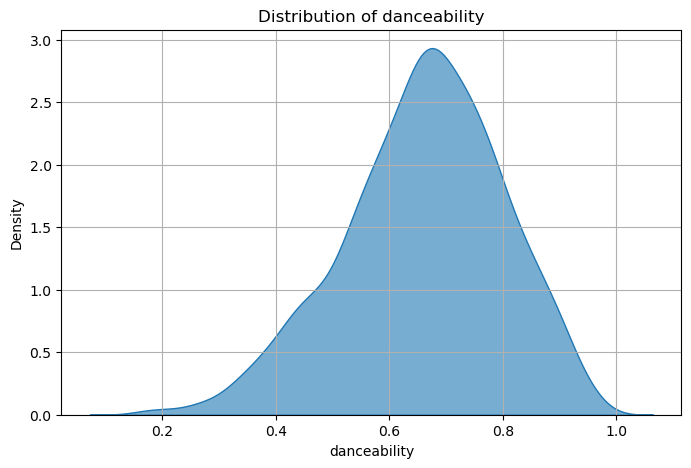

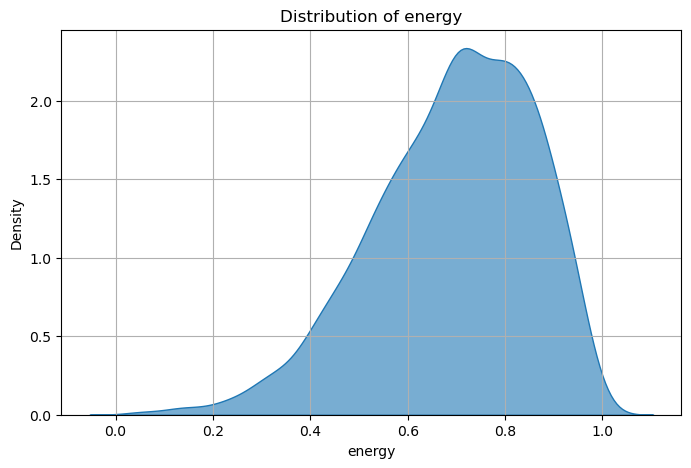

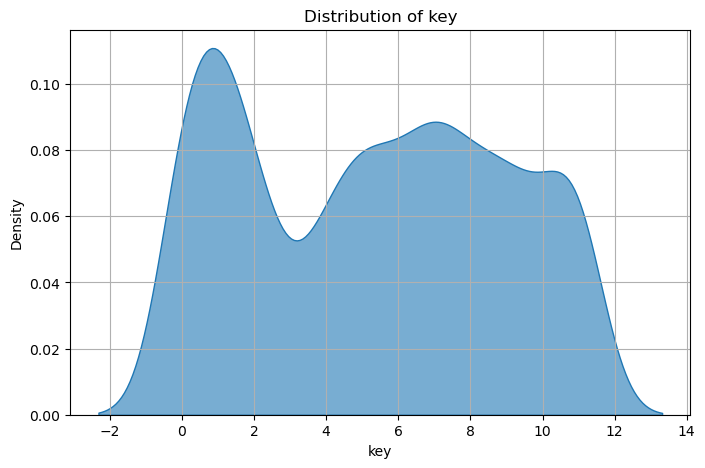

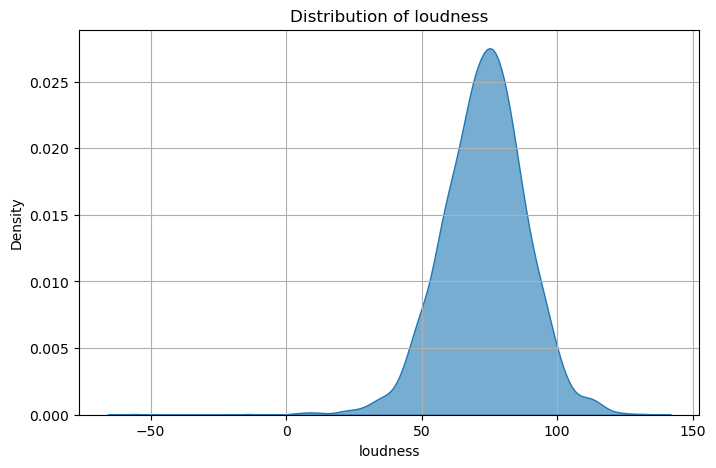

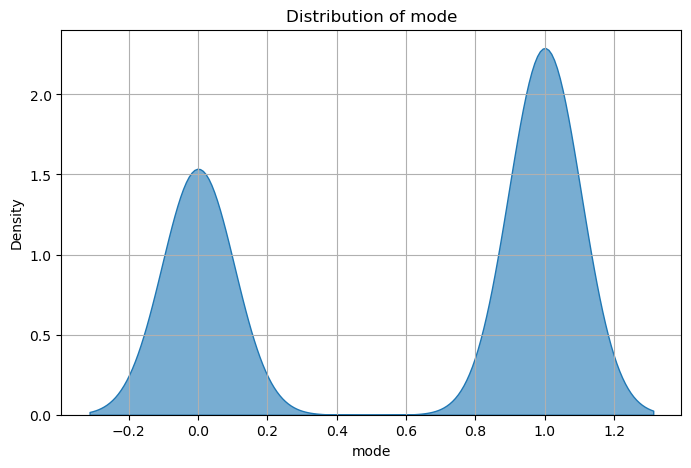

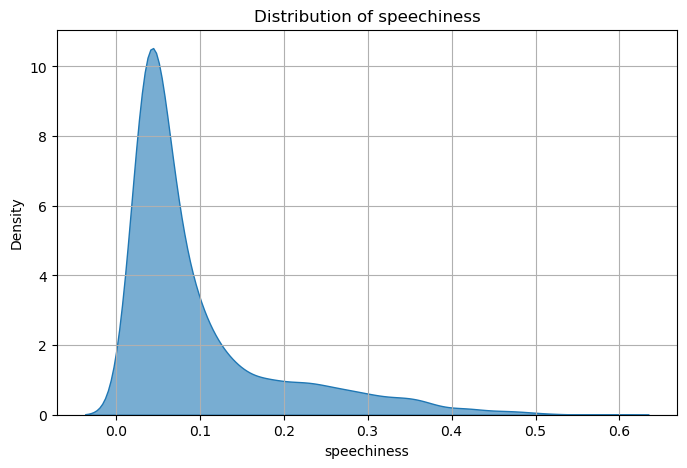

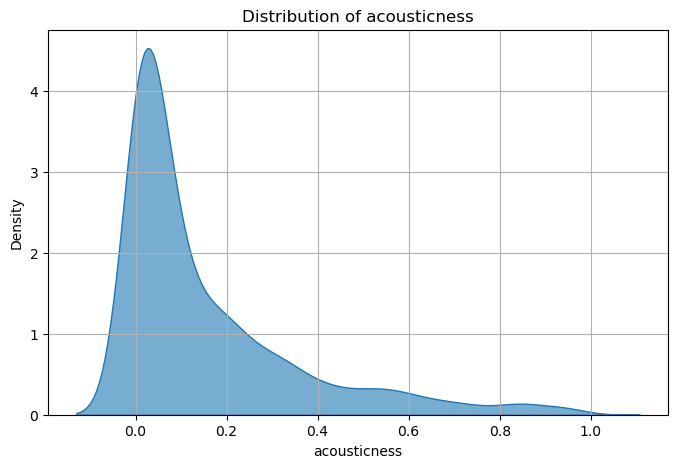

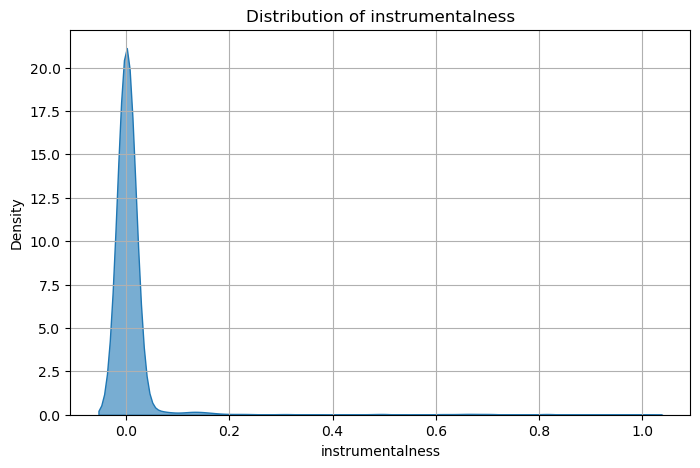

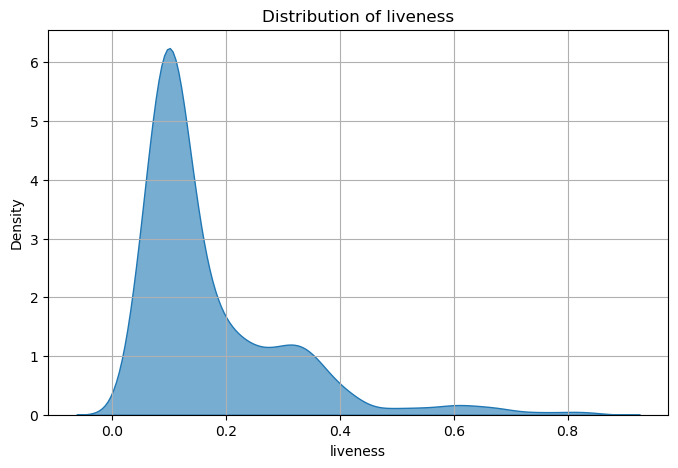

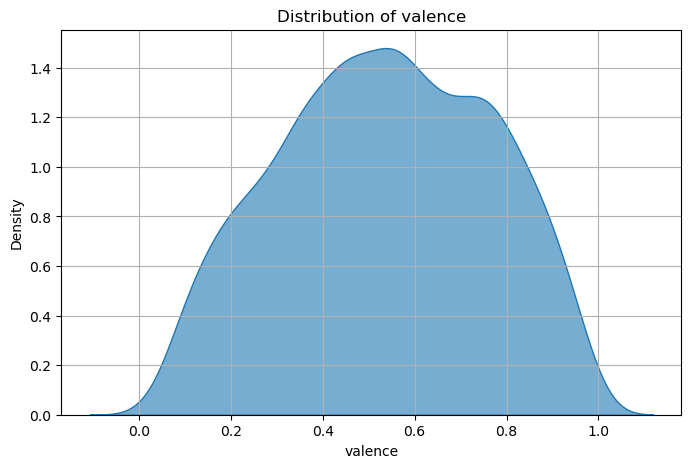

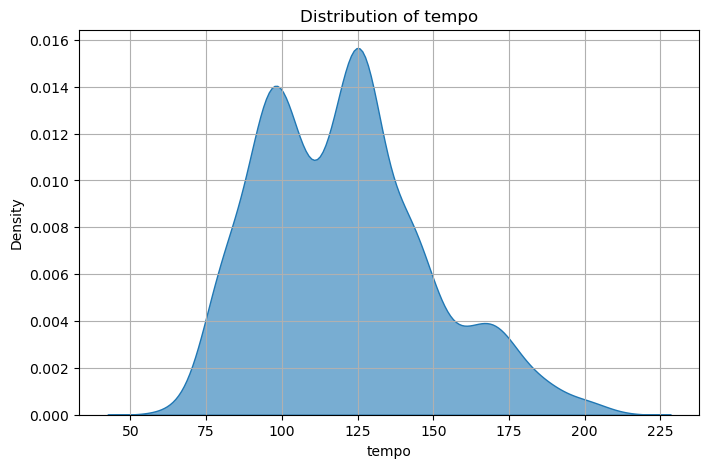

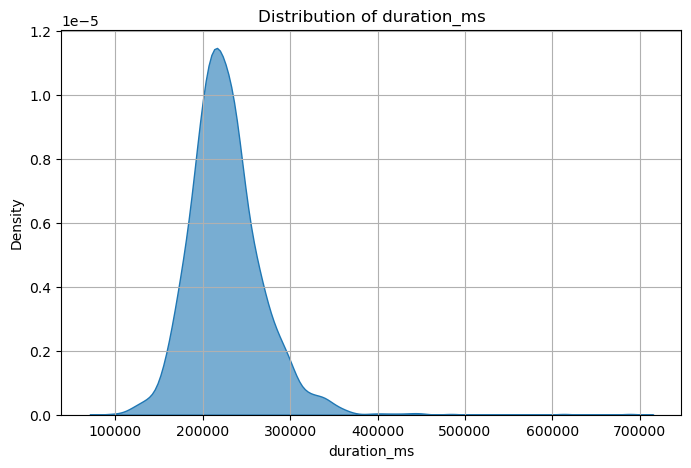

In [8]:
# Distribution of each KPI

kpis = ['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','duration_ms']

for kpi in kpis:
    plt.figure(figsize=(8, 5))
    sns.kdeplot(df[kpi].dropna(), fill=True, alpha=0.6)
    plt.title(f'Distribution of {kpi}')
    plt.xlabel(kpi)
    plt.ylabel('Density')
    plt.grid(True)
    plt.show()

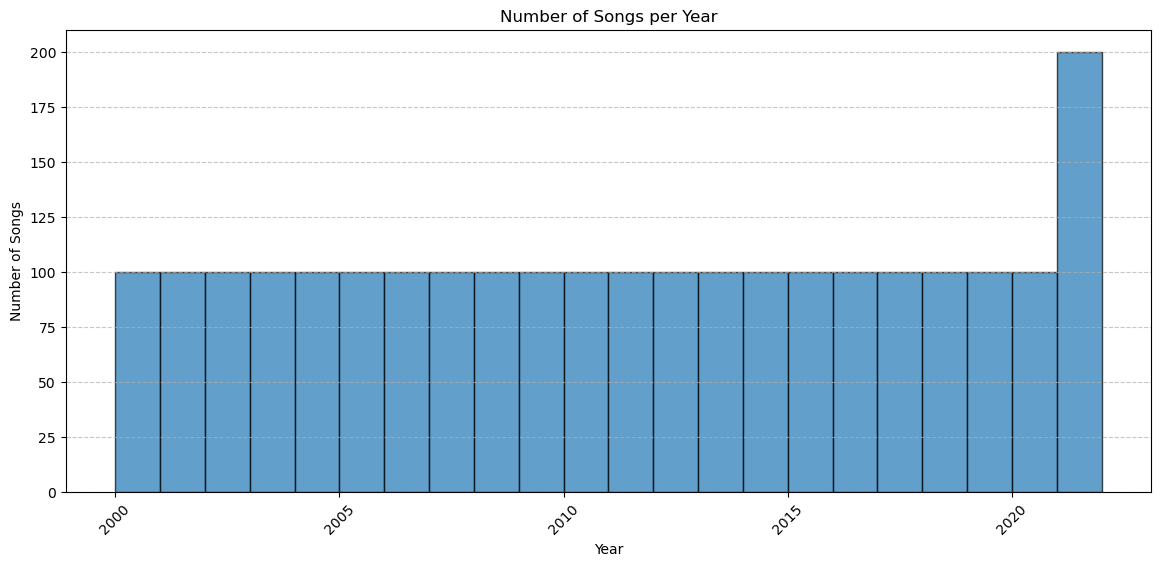

In [9]:
# Plot histogram of the # of songs per year
plt.figure(figsize=(14, 6))
plt.hist(df['year'], bins=range(df['year'].min(), df['year'].max() + 1), 
         edgecolor='black', alpha=0.7)
plt.xticks(rotation=45)
plt.xlabel('Year')
plt.ylabel('Number of Songs')
plt.title('Number of Songs per Year')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [10]:
# Top 10 artists by # of unique songs
top10_artists = (df.groupby('artist_name')[['track_name','artist_popularity']]
                 .agg({'track_name':'nunique','artist_popularity':'mean'})
                 .rename(columns={'track_name':'unique_tracks','artist_popularity':'avg_artist_popularity'})
                 .sort_values('unique_tracks',ascending=False)
                 .head(10))

top10_artists

,unique_tracks,avg_artist_popularity
artist_name,,
Drake,30,94.0
Taylor Swift,28,100.0
Rihanna,24,87.0
BeyoncÃ©,22,85.0
Calvin Harris,21,84.0
Ariana Grande,19,87.0
Justin Bieber,19,87.0
P!nk,19,79.0
Eminem,18,88.0


In [11]:
# Top 10 artists by decade

df['decade'] = df['year']//10 * 10

top10_artists_by_decade = (df.groupby(['decade','artist_name'])[['track_name','artist_popularity']]
                             .agg({'track_name':'nunique','artist_popularity':'mean'})
                             .rename(columns={'track_name':'unique_tracks','artist_popularity':'avg_artist_popularity'})
                             .sort_values(['decade','unique_tracks'],ascending=False)
                             .groupby('decade')
                             .head(10))

top10_artists_by_decade

unique_tracks  avg_artist_popularity
decade artist_name                                             
2020   Justin Bieber                  10                   87.0
       Taylor Swift                    9                  100.0
       Bad Bunny                       8                   94.0
       Billie Eilish                   8                   88.0
       Drake                           8                   94.0
       The Weeknd                      8                   94.0
       Doja Cat                        7                   86.0
       Ariana Grande                   6                   87.0
       BLACKPINK                       5                   83.0
       BTS                             5                   87.0
2010   Drake                          20                   94.0
       Calvin Harris                  19                   84.0
       Taylor Swift                   17                  100.0
       Katy Perry                     14                   82.0
       Rihanna                        14                   87.0
       Ariana Grande                  13                   87.0
       Ed Sheeran                     13                   87.0
       Bruno Mars                     12                   86.0
       One Direction                  10                   82.0
       Jason Derulo                    9                   77.0
2000   Eminem                         13                   88.0
       BeyoncÃ©                       12                   85.0
       Britney Spears                 12                   78.0
       Kanye West                     12                   89.0
       P!nk                           11                   79.0
       Black Eyed Peas                10                   78.0
       Avril Lavigne                   9                   73.0
       Christina Aguilera              9                   75.0
       Rihanna                         9                   87.0
       Westlife                        9                   67.0

<Axes: >

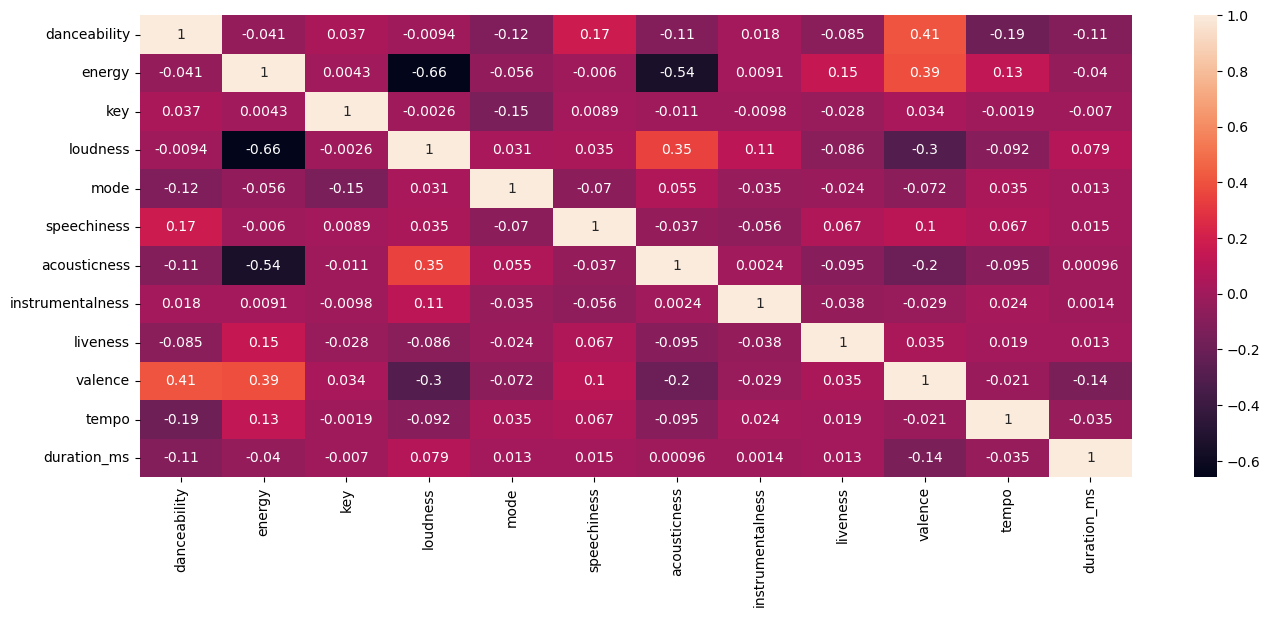

In [12]:
# Correlation between track popularity and KPIs

cols = ['artist_popularity'] + kpis

pop_kpi_df = df[kpis]

plt.figure(figsize=(16, 6))
sns.heatmap(pop_kpi_df.corr(),annot=True)

<Axes: >

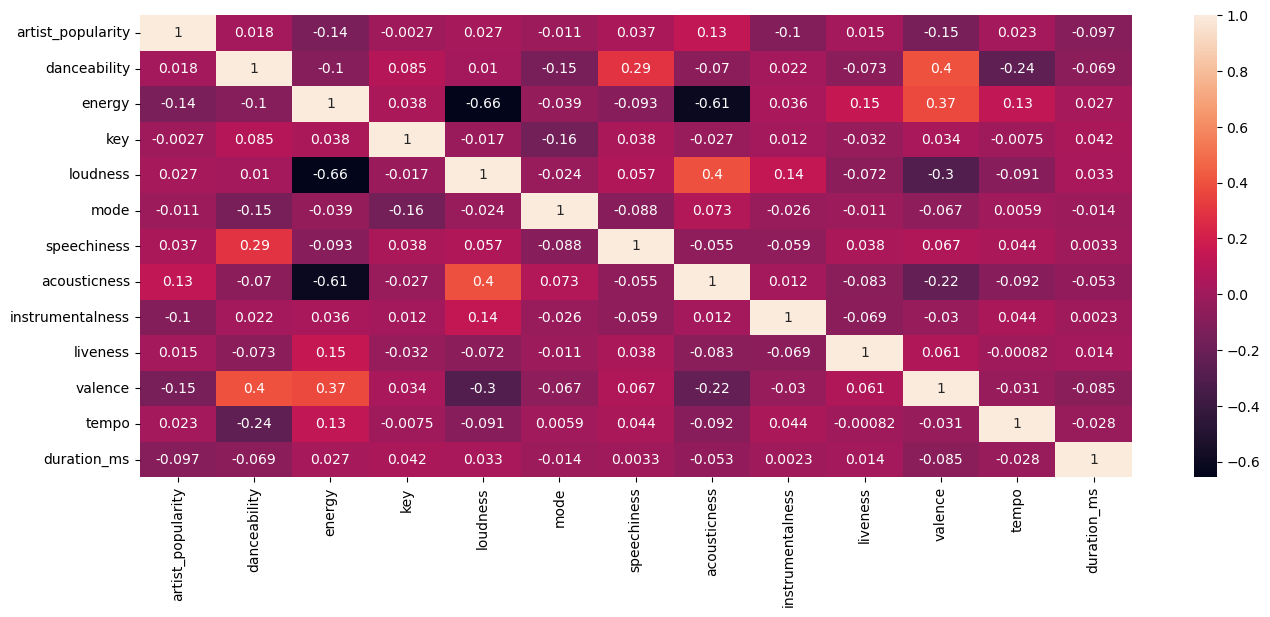

In [13]:
# Correlation between artist popularity and respective average KPIs

cols = ['artist_name', 'artist_popularity'] + kpis

artist_kpis = df[cols].groupby('artist_name')[['artist_popularity'] + kpis].mean()

plt.figure(figsize=(16, 6))
sns.heatmap(artist_kpis.corr(),annot=True)

## Data Cleaning

In [14]:
# check for NAs
df.isna().sum()

year                 0
track_name           0
track_popularity     0
album                0
artist_name          0
artist_genres        0
artist_popularity    0
danceability         1
energy               1
key                  1
loudness             1
mode                 1
speechiness          1
acousticness         1
instrumentalness     1
liveness             1
valence              1
tempo                1
duration_ms          1
track_id             0
Broader_Genres       0
decade               0
dtype: int64

In [15]:
# drop the one row with all KPIs as NA
df_encoded = df_encoded.drop(index=df_encoded[df_encoded['danceability'].isna()].index,axis=0)

# double check for any NAs left
df_encoded.isna().sum()

track_id             0
year                 0
track_name           0
track_popularity     0
album                0
artist_name          0
artist_genres        0
artist_popularity    0
danceability         0
energy               0
key                  0
loudness             0
mode                 0
speechiness          0
acousticness         0
instrumentalness     0
liveness             0
valence              0
tempo                0
duration_ms          0
Country/Folk         0
Electronic           0
Hip-Hop/Rap          0
Jazz/Blues           0
Latin                0
Metal                0
Pop                  0
R&B/Soul             0
Rock                 0
dtype: int64

In [16]:
kpis = ['year', 'track_popularity', 'artist_popularity', 'danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','duration_ms', 'acousticness']

# look at skewness of the numeric columns
skewness_df = pd.DataFrame(df_encoded[kpis].skew().sort_values(ascending=False))
skewness_df = skewness_df.rename(columns={0:'skew'})

highly_skewed_features = skewness_df[(skewness_df['skew']>1)|(skewness_df['skew']<-1)].index.values
highly_skewed_features

array(['instrumentalness', 'liveness', 'speechiness', 'acousticness',
       'acousticness', 'duration_ms', 'track_popularity'], dtype=object)

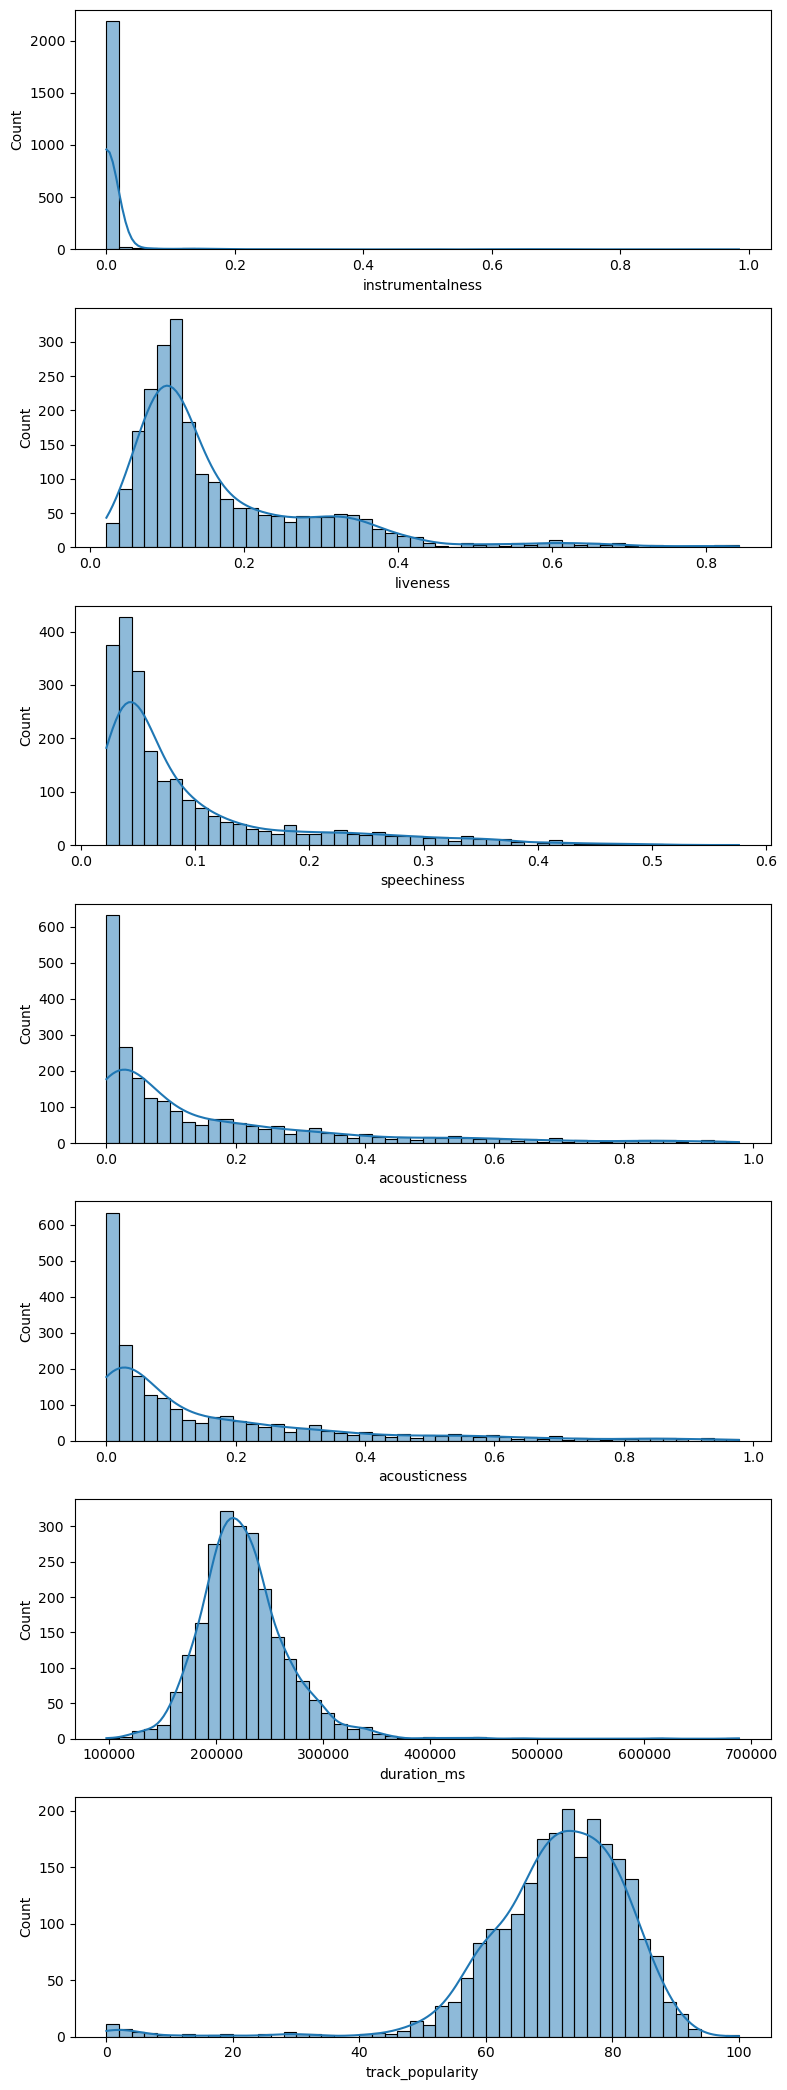

In [17]:
fig, axes = plt.subplots(nrows=len(highly_skewed_features), figsize=(8, 3 * len(highly_skewed_features)))
for i, col in enumerate(highly_skewed_features):
    sns.histplot(df_encoded[col], bins=50, kde=True, ax=axes[i])

plt.tight_layout()
plt.show()

In [18]:
# features to remove before segmentation that can be used for profiling
profiling_cols = ['track_id', 'year', 'track_popularity', 'track_name','album','artist_name','artist_genres','instrumentalness', 'duration_ms', 'key', 'energy']

# convert instrumentalness into a binary variable, log transform duration, convert mode to binary
df_encoded['log_duration_ms'] = np.log1p(df_encoded['duration_ms'])
df_encoded["key_sin"] = np.sin(2 * np.pi * df_encoded["key"] / 12)
df_encoded["key_cos"] = np.cos(2 * np.pi * df_encoded["key"] / 12)
df_encoded['mode'] = (df_encoded['mode']).astype(int)

selected_df = df_encoded.drop(columns=profiling_cols,axis=1)

selected_df.head(10)

,artist_popularity,danceability,loudness,mode,speechiness,acousticness,liveness,valence,tempo,Country/Folk,...,Hip-Hop/Rap,Jazz/Blues,Latin,Metal,Pop,R&B/Soul,Rock,log_duration_ms,key_sin,key_cos
0,62,0.659,87.0,0,0.0487,0.230000,0.0951,0.888,83.014,0,...,0,0,0,0,0,1,0,12.367911,0.866025,-0.500000
1,49,0.481,71.0,1,0.0660,0.000891,0.0939,0.660,96.493,0,...,0,0,0,0,1,0,0,12.151268,-0.500000,-0.866025
2,76,0.542,80.0,1,0.0299,0.490000,0.1010,0.218,117.763,0,...,0,0,0,0,1,0,0,12.215696,0.500000,0.866025
3,75,0.434,69.0,1,0.0488,0.010300,0.6120,0.684,148.726,0,...,0,0,0,1,1,0,1,12.026156,0.000000,1.000000
4,57,0.561,92.0,1,0.0324,0.260000,0.1240,0.243,139.803,1,...,0,0,0,0,0,0,0,12.392004,0.500000,0.866025
5,35,0.624,49.0,1,0.0343,0.069800,0.0867,0.914,104.770,0,...,0,0,0,0,0,0,0,12.293172,-0.500000,-0.866025
6,65,0.724,95.0,0,0.0841,0.365000,0.0969,0.578,151.181,0,...,0,0,0,0,0,1,0,12.762523,0.500000,-0.866025
7,69,0.487,78.0,1,0.0238,0.005280,0.1290,0.306,95.982,0,...,0,0,0,1,0,0,1,12.490906,-0.500000,-0.866025
8,75,0.683,73.0,0,0.0329,0.039500,0.0483,0.542,121.996,0,...,0,0,0,0,1,0,0,12.298474,0.500000,0.866025
9,75,0.539,81.0,1,0.0499,0.014000,0.3600,0.454,136.279,0,...,0,0,0,0,0,0,1,12.414716,0.866025,0.500000


In [19]:
# SCALE THE DATA SPECIFIC TO EACH COLUMN

# Select features for each type of scaling
standard_features = ["artist_popularity", "tempo", "log_duration_ms", "key_sin", "key_cos"]
minmax_features = ["danceability", "acousticness", "liveness", "valence"]
robust_features = ["loudness", "speechiness"]  # RobustScaler for outliers

# Initialize scalers
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()
robust_scaler = RobustScaler()

# Apply scalers
selected_df[standard_features] = standard_scaler.fit_transform(selected_df[standard_features])
selected_df[minmax_features] = minmax_scaler.fit_transform(selected_df[minmax_features])
selected_df[robust_features] = robust_scaler.fit_transform(selected_df[robust_features])

# Keep binary-encoded columns (mode + genre labels) as is
binary_features = ["mode", "Country/Folk", "Electronic", "Hip-Hop/Rap", "Jazz/Blues",
                   "Latin", "Metal", "Pop", "R&B/Soul", "Rock"]

print("Scaling completed! Dataset is now ready for K-Means.")

Scaling completed! Dataset is now ready for K-Means.


## K-Means With 4, 5, and 6 Clusters

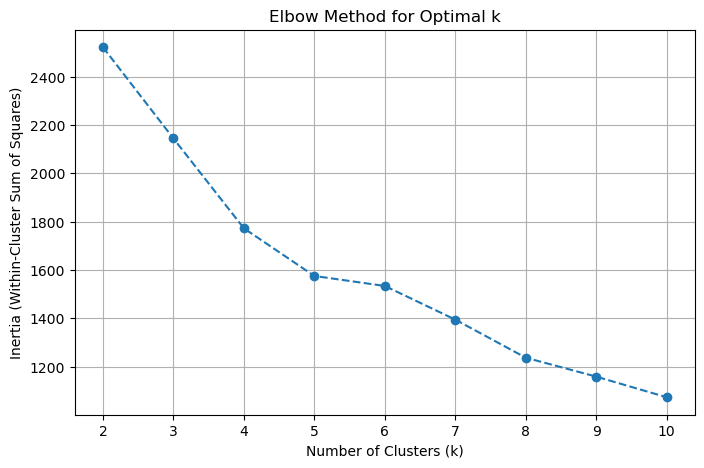

In [20]:
features = ['Country/Folk', 'Electronic', 'Hip-Hop/Rap', 'Jazz/Blues', 'Latin', 'Metal', 'Rock', 'Pop', 'R&B/Soul', 'speechiness', 'liveness']

scaled_df = selected_df[features]

# Step 2: Run K-Means for Different k Values
inertia = []
cluster_range = range(2, 11)  # Try k from 2 to 10

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    kmeans.fit(scaled_df)
    inertia.append(kmeans.inertia_)  # Inertia = within-cluster sum of squares

# Step 3: Plot Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia, marker='o', linestyle='--')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Within-Cluster Sum of Squares)")
plt.title("Elbow Method for Optimal k")
plt.xticks(cluster_range)
plt.grid()
plt.show()

In [21]:
# Run K-Means with new hybrid-scaled data
best_k = 4  # Use the elbow method to choose
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init="auto")
labels = kmeans.fit_predict(scaled_df)

# Assign clusters back to DataFrame
selected_df["Cluster"] = labels

# Compute Silhouette Score
sil_score = silhouette_score(scaled_df, labels)
print(f"Silhouette Score with Hybrid Scaling: {sil_score:.4f}")

# Display cluster sizes
unique_clusters, counts = np.unique(labels, return_counts=True)
print(f"Cluster Sizes: {dict(zip(unique_clusters, counts))}")

Silhouette Score with Hybrid Scaling: 0.3352
Cluster Sizes: {0: 198, 1: 1301, 2: 432, 3: 368}


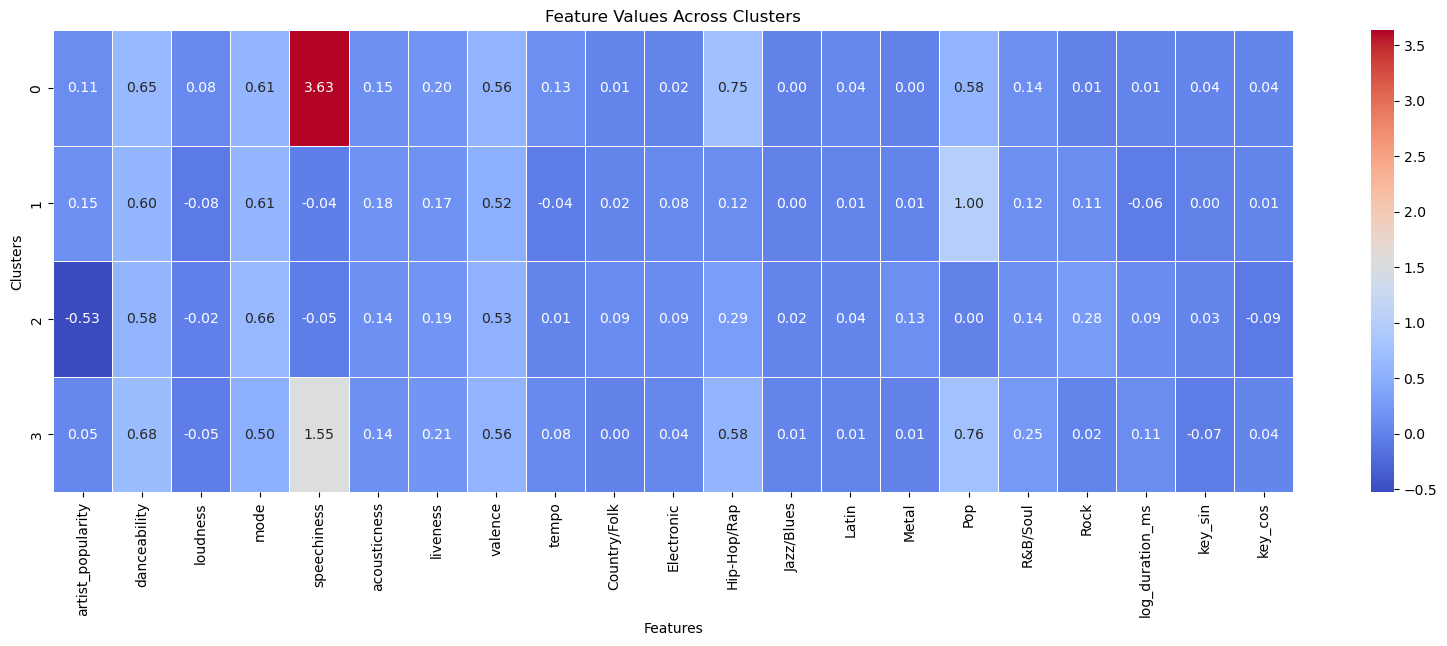

In [22]:
# Step 1: Analyze Cluster Centers
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=scaled_df.columns)
cluster_centers["Cluster"] = cluster_centers.index

# Step 2: Compute Feature Averages Per Cluster
cluster_summary = selected_df.groupby("Cluster").mean()


plt.figure(figsize=(20, 6))
sns.heatmap(cluster_summary, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

# Titles and labels
plt.title("Feature Values Across Clusters")
plt.xlabel("Features")
plt.ylabel("Clusters")

# Show plot
plt.show()

In [23]:
# Run K-Means with new hybrid-scaled data
best_k = 5  # Use the elbow method to choose
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init="auto")
labels = kmeans.fit_predict(scaled_df)

# Assign clusters back to DataFrame
selected_df["Cluster"] = labels

# Compute Silhouette Score
sil_score = silhouette_score(scaled_df, labels)
print(f"Silhouette Score with Hybrid Scaling: {sil_score:.4f}")

# Display cluster sizes
unique_clusters, counts = np.unique(labels, return_counts=True)
print(f"Cluster Sizes: {dict(zip(unique_clusters, counts))}")

Silhouette Score with Hybrid Scaling: 0.3463
Cluster Sizes: {0: 172, 1: 1169, 2: 320, 3: 296, 4: 342}


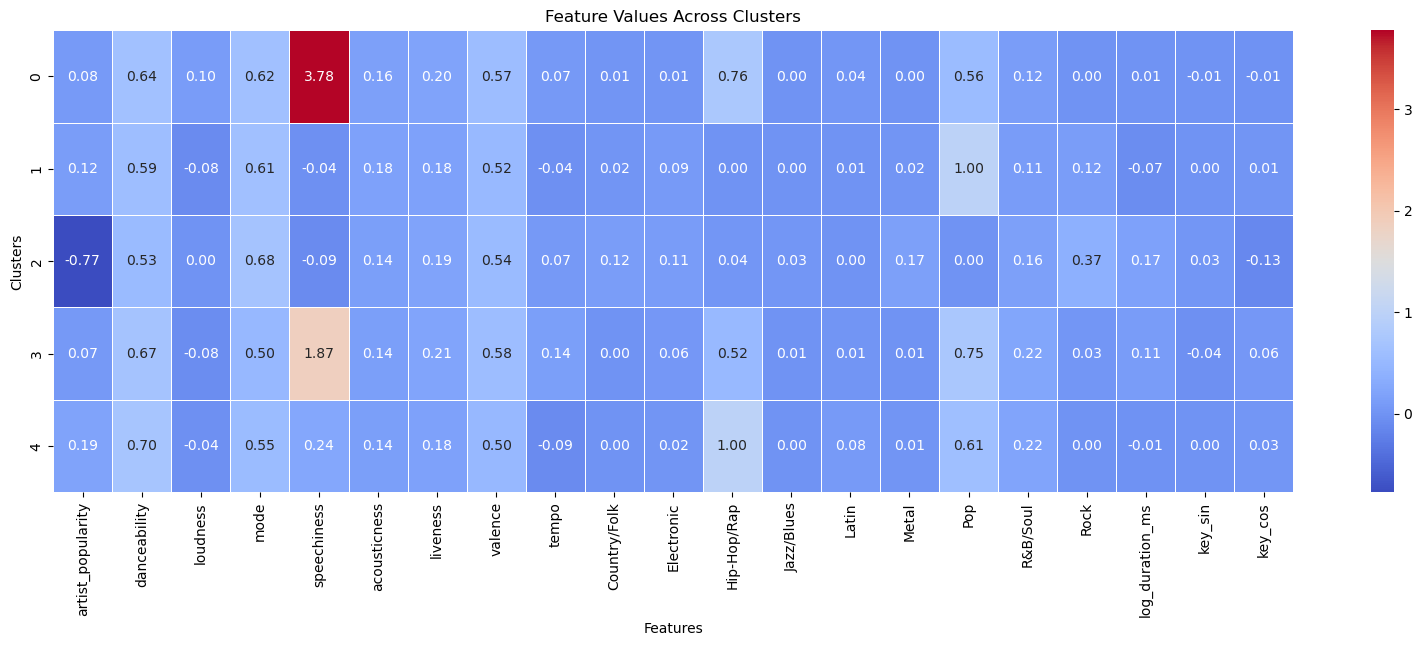

In [24]:
# Step 1: Analyze Cluster Centers
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=scaled_df.columns)
cluster_centers["Cluster"] = cluster_centers.index

# Step 2: Compute Feature Averages Per Cluster
cluster_summary = selected_df.groupby("Cluster").mean()


plt.figure(figsize=(20, 6))
sns.heatmap(cluster_summary, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

# Titles and labels
plt.title("Feature Values Across Clusters")
plt.xlabel("Features")
plt.ylabel("Clusters")

# Show plot
plt.show()

In [25]:
# Run K-Means with new hybrid-scaled data
best_k = 6  # Use the elbow method to choose
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init="auto")
labels = kmeans.fit_predict(scaled_df)

# Assign clusters back to DataFrame
selected_df["Cluster"] = labels

# Compute Silhouette Score
sil_score = silhouette_score(scaled_df, labels)
print(f"Silhouette Score with Hybrid Scaling: {sil_score:.4f}")

# Display cluster sizes
unique_clusters, counts = np.unique(labels, return_counts=True)
print(f"Cluster Sizes: {dict(zip(unique_clusters, counts))}")

Silhouette Score with Hybrid Scaling: 0.2867
Cluster Sizes: {0: 111, 1: 1042, 2: 418, 3: 137, 4: 370, 5: 221}


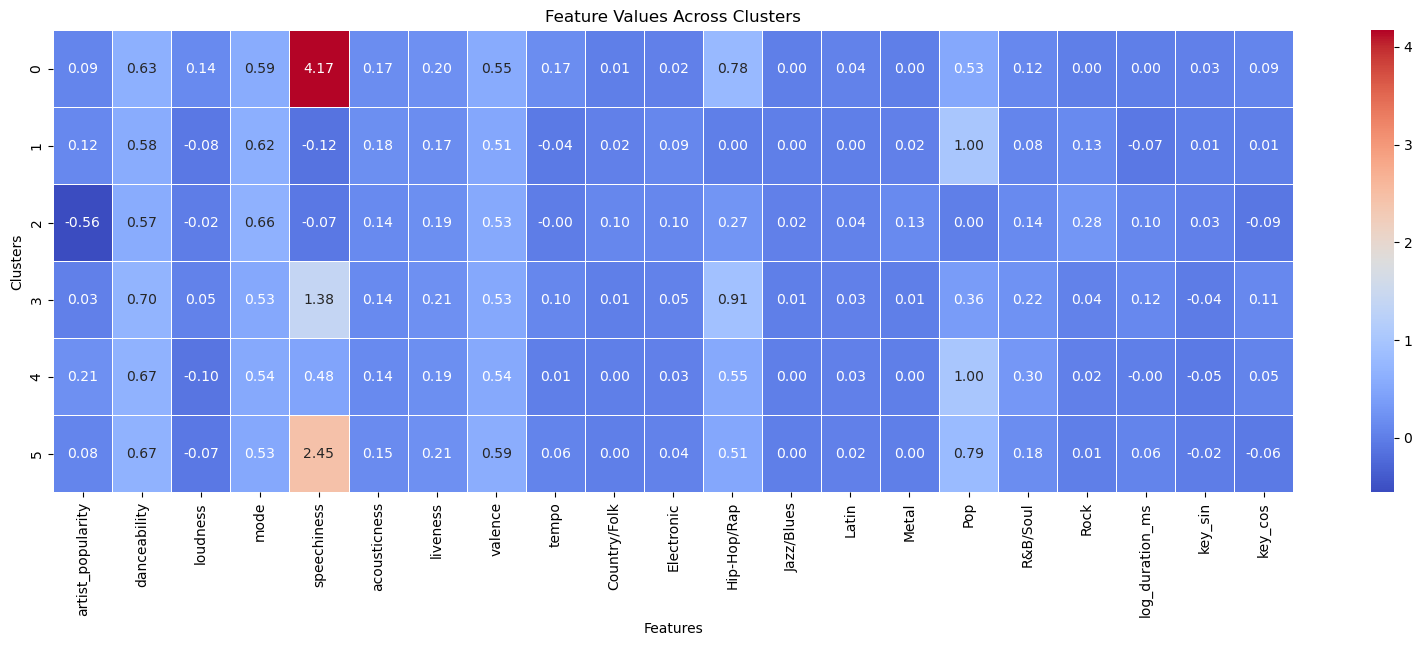

In [26]:
# Step 1: Analyze Cluster Centers
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=scaled_df.columns)
cluster_centers["Cluster"] = cluster_centers.index

# Step 2: Compute Feature Averages Per Cluster
cluster_summary = selected_df.groupby("Cluster").mean()


plt.figure(figsize=(20, 6))
sns.heatmap(cluster_summary, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

# Titles and labels
plt.title("Feature Values Across Clusters")
plt.xlabel("Features")
plt.ylabel("Clusters")

# Show plot
plt.show()